# Premissas


- dados faltantes não foram coletados para preservar o anonimato segundo LGPD.
- colunas start_station_id, end_station_id, start_station_name e end_station_name foram preenchidos com valor 0 (zero), são bikes guardadas dentro da casa do cliente.
- colunas start_lat, start_lng, foram preenchidos com valor 0 (zero).

# 0.0 Importações

In [4]:
import pandas as pd
import seaborn as sns
from IPython.display import Image
import time

## 0.1. Carregando os dados

In [5]:
df1 = pd.read_csv("May_2020.csv",low_memory=False)
df2 = pd.read_csv("Jun_2020.csv",low_memory=False)
df3 = pd.read_csv("Jul_2020.csv",low_memory=False)
df4 = pd.read_csv("Aug_2020.csv",low_memory=False)




In [6]:
data1 = pd.concat([df1,df2])
data2 = pd.concat([df3,df4])





# 1.0. Descrição dos dados

## 1.1. Dimensão dos dados

In [7]:
print('numero de linhas: {}'.format(data1.shape[0]))
print('numero de colunas: {}'.format(data1.shape[1]))

numero de linhas: 627161
numero de colunas: 13


In [8]:
print('numero de linhas: {}'.format(data2.shape[0]))

print('numero de colunas: {}'.format(data2.shape[1]))

numero de linhas: 894485
numero de colunas: 13


## 1.2. Tipos dos dados

In [9]:
data1['started_at'] = pd.to_datetime(data1['started_at'])
data1['ended_at'] = pd.to_datetime(data1['ended_at'])

data1.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               int64
end_station_name              object
end_station_id               float64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [10]:
data2['started_at'] = pd.to_datetime(data2['started_at'])
data2['ended_at'] = pd.to_datetime(data2['ended_at'])

data1.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               int64
end_station_name              object
end_station_id               float64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

## 1.3. Checando NA

In [11]:
data1.isnull().sum()

ride_id                 0
rideable_type           0
started_at              0
ended_at                0
start_station_name      0
start_station_id        0
end_station_name      322
end_station_id        322
start_lat               0
start_lng               0
end_lat               322
end_lng               322
member_casual           0
dtype: int64

In [12]:
data1['end_station_name'] = data1['end_station_name'].fillna("house")
data1['end_station_id'] = data1['end_station_id'].fillna(0)
data1['end_lat'] = data1['end_lat'].fillna(0)
data1['end_lng'] = data1['end_lng'].fillna(0)

In [13]:
data2.isnull().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name     149
start_station_id       152
end_station_name      1435
end_station_id        1437
start_lat                0
start_lng                0
end_lat               1238
end_lng               1238
member_casual            0
dtype: int64

In [14]:
data2['start_station_name']=data2['start_station_name'].fillna("house")
data2['start_station_id']=data2['start_station_id'].fillna(0)
data2['end_station_name']=data2['end_station_name'].fillna("house")
data2['end_station_id']=data2['end_station_id'].fillna(0)
data2['end_lat']=data2['end_lat'].fillna(0)
data2['end_lng']=data2['end_lng'].fillna(0)

## 1.4. Checando tipos dos dados

In [43]:
data1.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id               int64
end_station_name              object
end_station_id                 int64
start_lat                     object
start_lng                     object
end_lat                       object
end_lng                       object
member_casual                 object
dtype: object

In [42]:
data1['start_station_id']= data1['start_station_id'].astype('int64')
data1['end_station_id']= data1['end_station_id'].astype('int64')
data1['start_lat']= data1['start_lat'].astype(str)
data1['start_lng']= data1['start_lng'].astype(str)
data1['end_lat']= data1['end_lat'].astype(str)
data1['end_lng']= data1['end_lng'].astype(str)


In [17]:
data2.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id             float64
end_station_name              object
end_station_id               float64
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [18]:
data2['end_station_id']= data2['end_station_id'].astype('int64')
data2['start_station_id']= data2['start_station_id'].astype('int64')


# 2.0 Feature Engineering

In [63]:
data3 = data1.copy()
data4 = data2.copy()

## 2.1. Mapa mental Hipoteses

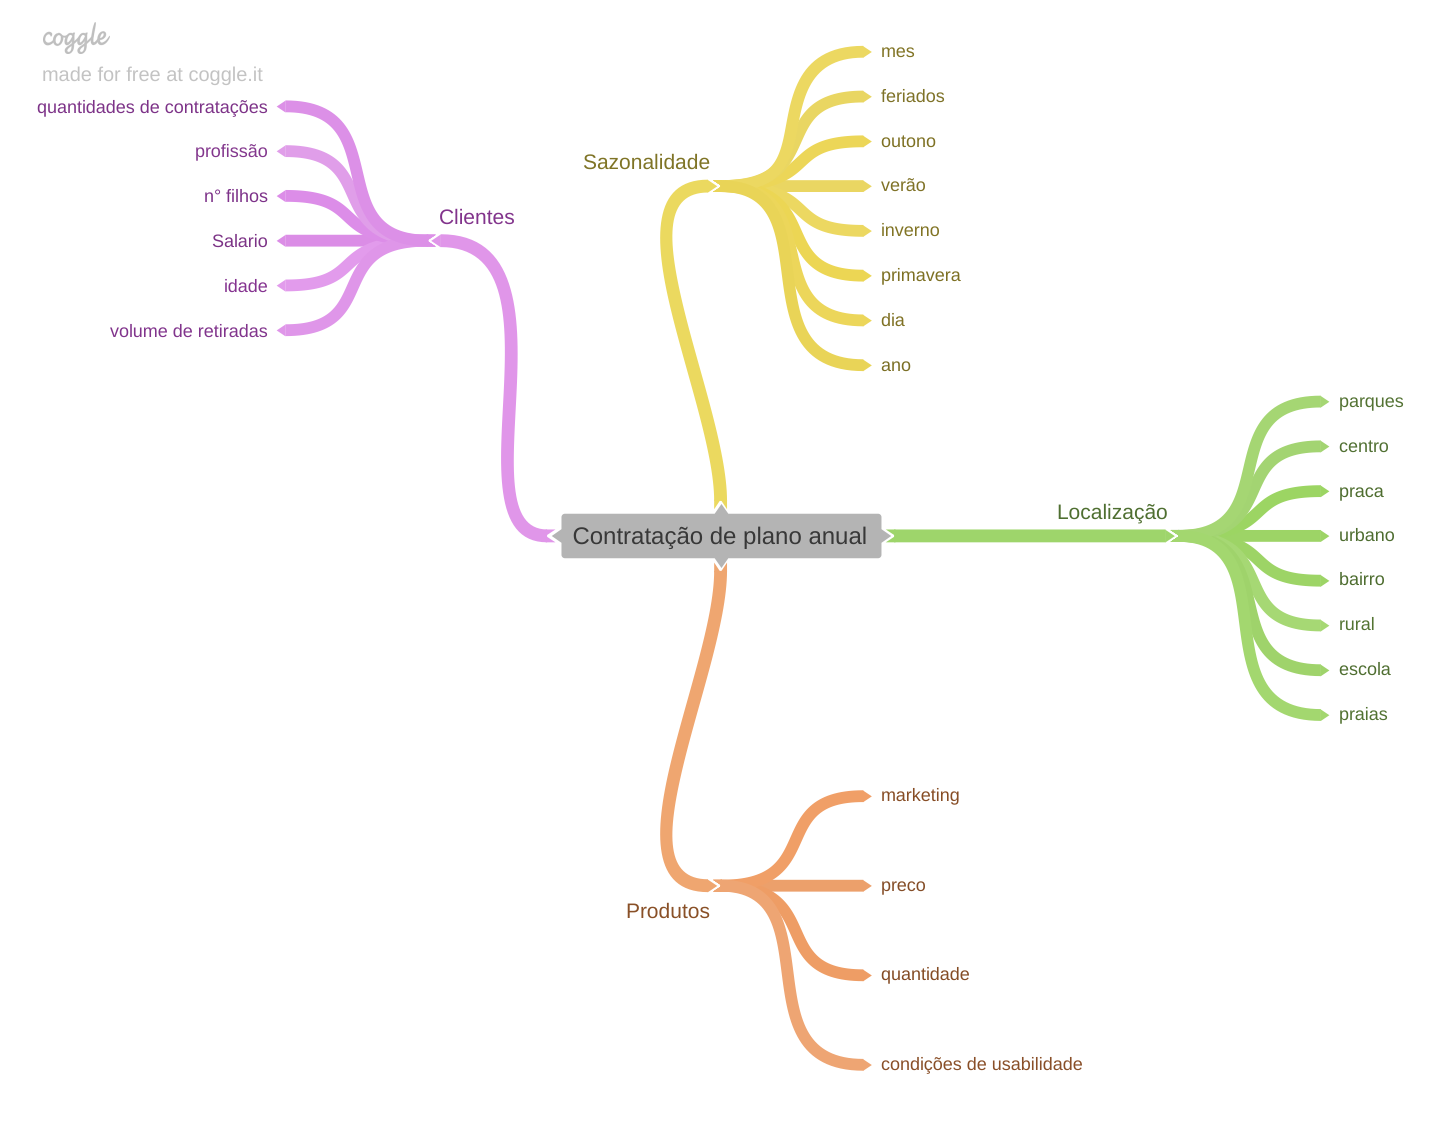

In [64]:
Image('C:/Users/wesle/source/repos/projetos_ds/ciclystic/img/mapamental_hipoteses.png')

## 2.2. Criaçãos das Hipóteses

### 2.2.1. Hipoteses Clientes

**1.** Clientes com contratação anual traz mais retorno financeiro.

**2.** A profissão influencia nas contratações.

**3.** Clientes com filhos são mais propensos a contratação anual.

**4.** Clientes com salário maior são menos propensos a contratação anual.

**5.** Clientes com idade inferior a 25 anos são a maioria de clientes casuais.

**6.** Clientes com contratação casual fazem mais retiradas.

### 2.2.2. Hipóteses Produtos

**1.** O maior investimento em marketing aumentam as contratações.

**2.** Passes de viagem unica são mais baratos quando comparado ao anual.

**3.** A quantidade de bikes usadas por familia influencia no preço.

**4.** A quantidade de bikes atendem a quantidade clientes do momento.

**5.** Bikes com melhor usabilidade(tipo) são mais usadas.


### 2.2.3. Hipóteses Localização

**1.** Parques são mais frequentados do que centros.

**2.** Centros possuem mais retiradas de bikes.

**3.** Praças possuem menor retiradas de bikes.

**4.** Ambientes urbanos são mais frequentados que o centro.

**5.** Bairros proximos ao centro são onde possuem menos retiradas de bikes.

**6.** Ambientes rurais são mais frequentados por quem faz retirada no centro.

**7.** Estação de bikes proximos a escola são 30% mais frequentados que centro.

**8.** Estações de bikes próximos a praia são mais frequentados do que parques.





### 2.2.4. Hipóteses Temporal

**1.** A segunda quinzena do mês tem mais usuarios usando as bikes.

**2.** A quantidade de retirada e devolução é a mesma durante os dias.

**3.** A contratação Anual teve um aumento de 20% no ano.

**4.** No verão a frequencia de usuarios aumentam 30%.

**5.** No inverno a frequencia de usuarios caem 30%.

**6.** No verão as estações de bikes nas praias aumentam 40%.

**7.** No inverno as estações de bikes nos centros aumentam 15%.

**8.** Outono e Primavera são estações do ano com menor numero de usuarios.

**9.** A cada mês há um aumento de 10% .

## 2.3 Lista final de hipoteses

**1.** Clientes com contratação casual fazem mais retiradas.

**2.** A quantidade de bikes atendem a quantidade clientes do momento.

**3.** Bikes com melhor usabilidade(tipo) são mais usadas.

**4.** Parques são mais frequentados do que centros.

**5.** Centros possuem mais retiradas de bikes.

**6.** Praças possuem menor retiradas de bikes.

**7.** Ambientes urbanos são mais frequentados que o centro.

**8.** Bairros proximos ao centro são onde possuem menos retiradas de bikes.

**9.** Ambientes rurais são mais frequentados por quem faz retirada no centro.

**10.** Estação de bikes proximos a escola são 30% mais frequentados que centro.

**11.** Estações de bikes próximos a praia são mais frequentados do que parques.

**12.** No verão a frequencia de usuarios aumentam 30%.

**13.** No inverno a frequencia de usuarios caem 30%.

**14.** No verão as estações de bikes nas praias aumentam 40%.

**15.** No inverno as estações de bikes nos centros aumentam 15%.

**16.** Outono e Primavera são estações do ano com menor numero de usuarios.

**17.** A cada mês há um aumento de 10% .








## 2.4 Feature Engineering

In [74]:
#ano
data3['year']=data3['started_at'].dt.year

#mês
data3['month']=data3['started_at'].dt.month

#dia
data3['day']=data3['started_at'].dt.day

#tipo da semana : final de semana ou semana comum  Segunda=0, Domingo=6.
data3['type_week_numeric']=data3['started_at'].dt.weekday
data3['type_week_categoric']= data3['type_week_numeric'].apply(lambda x: "weekday" if x < 5 else "weekend")

#hora por dia
data3['start_hour'] = data3['started_at'].dt.strftime("%H")
data3['start_hour']

#minutos por dia
data3['duration_seg']=data3['ended_at'] - data3['started_at']
data3['duration_min'] = data3['duration_seg']/60

#estacoes do ano
data3['season']= data3['month'].apply(lambda x: "spring" if (x >=3 & x<=5) else
                                                      "summer" if (x>=6 & x<=8) else
                                                       "fall" if (x>=9 & x<= 11) else
                                                       "winter")

# inicio e final da viagem (latitude e Longitude)
# query = str( data_reduze.loc[i, 'lat'] ) + ',' + str( data_reduze.loc[i, 'long'] )

data3['start_lat_lon']= str(data3.loc[i,'start_lat']) + "," + str(data3.loc[i,'start_lng'])
data3['end_lat_lon']=   str(data3.loc[i,'end_lat']) + "," + str(data3.loc[i,'end_lng']) 



In [75]:
#ano
data4['year']=data4['started_at'].dt.year

#mês
data4['month']=data4['started_at'].dt.month

#dia
data4['day']=data4['started_at'].dt.day

#tipo da semana : final de semana ou semana comum  Segunda=0, Domingo=6.
data4['type_week_numeric']=data4['started_at'].dt.weekday
data4['type_week_categoric']= data4['type_week_numeric'].apply(lambda x: "weekday" if x < 5 else "weekend")

#hora por dia
data4['start_hour'] = data4['started_at'].dt.strftime("%H")
data4['start_hour']

#minutos por dia
data4['duration_seg']=data4['ended_at'] - data4['started_at']
data4['duration_min'] = data4['duration_seg']/60

#estacoes do ano
data4['season']= data4['month'].apply(lambda x: "spring" if (x >=3 & x<=5) else
                                                      "summer" if (x>=6 & x<=8) else
                                                       "fall" if (x>=9 & x<= 11) else
                                                       "winter")

# inicio e final da viagem (latitude e Longitude)
# query = str( data_reduze.loc[i, 'lat'] ) + ',' + str( data_reduze.loc[i, 'long'] )

data4['start_lat_lon']= str(data4.loc[i,'start_lat']) + "," + str(data4.loc[i,'start_lng'])
data4['end_lat_lon']=   str(data4.loc[i,'end_lat']) + "," + str(data4.loc[i,'end_lng']) 

